# "Энергетический оракул" - 2 этап - почасовое энергопотребление

**Задача:**

Разработка модели прогнозирования общего энергопотребления региона на каждый час, в МВт*ч

**Цель:**  
Разработать надежную и точную модель прогнозирования объема
энергопотребления на сутки для Калининградской области с использованием
доступных исторических данных и соответствующих переменных.


**Данные:**

- `train_dataset.csv` – исторические данные о потреблении энергии за период 2019-01-01 - 2023-03-31
     * *date* – дата;
     * *time* – время,  время  представлено  в  диапазоне  0  –  23,  что  означает  24 часа в сутках;
     * *target* – фактическое потребление на указанную дату;
     * *temp* – фактическая температура на указанную дату;
     * *temp_pred* – прогноз температуры на указанную дату;
     * *weather_fact* – фактическая погода на указанную дату;
     * *weather_pred* – прогноз погоды на указанную дату;


- `test_dataset.csv` – исторические данные о потреблении энергии за период 2023-04-01 – 2023-07-31


**Метрики качества**:
- MAE (Главная метрика)
- MAPE (Вспомогательная метрика)
- R2-score (Вспомогательная метрика)
  


In [78]:
# requirments.txt для ноутбука
# !pip install pandas==2.0.0
# !pip install numpy==1.23.5 
# !pip install seaborn==0.11.1 
# !pip install phik==0.10.0 
# !pip install sklearn==1.2.2 
# !pip install statsmodels==0.13.2 
# !pip install lightgbm==3.3.5 
# !pip install joblib==1.2.0 
# !pip install matplotlib==3.7.1 
# !pip install nltk==3.8.1

In [79]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import datetime
import warnings
import phik
import copy
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from phik import phik_matrix

from lightgbm import LGBMRegressor
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import  CountVectorizer
from datetime import timedelta
from sklearn.ensemble import StackingRegressor

warnings.filterwarnings('ignore')

seed = 42

##  Моделирование
Перед нами стоит задача прогнозирования суммарного электропотребления за сутки.
- Загрузим обучающую и тестовые выборки и сгенерируем новые признаки
- При помощи кросс-валидации в GridSearch осуществим подбор гиперпараметров, оценку качества и выбор лучшей модели

Метрикой для оценки качества и выбора модели - средняя абсолютная ошибка MAE для часа. На тестовой выборке оценивается MAE для суммарного потребления в сутки.  
Дополнительные будем оценивать среднюю абсолютную ошибку в процентах MAPE и коэффициент детерминации R2.

Для моделирования был выбран градиентный бустинг LightGBM за известный успешный опыт применения для решения подобных задач, скорость и возможность обработки пропусков.

Раздел моделирования сделан независимо от предыдущего с EDA.

### Подготовка выборок
**Загрузка исходных данных**

In [113]:
# загрузка данных
train_name = 'train_dataset.csv'
test_name = 'test_dataset.csv'
# ззагрузка с парсингом признака с датой
train = pd.read_csv(train_name, parse_dates=['date'])
test = pd.read_csv(test_name, parse_dates=['date'])
print('Train:', train.shape, '\nTest:', test.shape)

Train: (37224, 7) 
Test: (2928, 7)


**Функции для Feature Engineering**

In [112]:
# общая функция для генерации всех признаков
def feature_engineering_func(dataset):
    df = dataset.copy()
    # замена пропусков погодных признаков предыдущим значением
    df[['temp_pred', 'weather_pred', 'weather_fact']] = df[['temp_pred', 'weather_pred', 'weather_fact']].ffill()

    # влажность
    df = humidity_from_text_weather(df)

    # загрузка count_vectorizer 
    count_vectorizer = joblib.load('count_vectorizer.pkl')
    df = vectorize_weather_pred(df, count_vectorizer)

    # календарные признаки
    df = create_features(df)

    # лаговые
    df = create_lag_rolling(df)
    
    return df


# функция достать относительную влажность из описания погоды
def humidity_from_text_weather(dataset):
    data = dataset.copy()
    # оставляем только цифры, переводим в float    
    data['humidity'] = data['weather_pred'].fillna('').apply(lambda text: re.sub(r'[^0-9]', ' ', text))
    data['humidity'] = pd.to_numeric(data['humidity'], errors='coerce')
    data.loc[data['humidity']>100, 'humidity'] = np.nan
    return data

# обработка текста в weather_pred:
# функция для очистки текста
def preprocess_text(text):
    # перевести текст в нижний регистр
    text = text.lower()
    # заменить ё на е
    text.replace('ё', 'е')
    # оставляем только буквы 
    text = re.sub(r'[^а-я]', ' ', text)
    # Токенизация 
    text = nltk.word_tokenize(text)
    # Соединяем в текст 
    text = " ".join(text)
    # осттавить слова, содержащие не менее 3 символов
    text = re.sub(r'\b\w{1,2}\b', '', text)
    return text

# векторизация, записываем каждое слово weather_pred как отдельный столбец (наиболее часто встречающиеся слова)
def vectorize_weather_pred(data_test, count_vectorizer):
    data = data_test.copy()
    # очистили текст
    data['weather_pred'] = data['weather_pred'].fillna('').apply(lambda x: preprocess_text(x))

    # создаст матрицу: столбцы слова, значения бинарные
    text_vector = count_vectorizer.transform(data['weather_pred'])
    # преобразуем в датафрейм
    text_df = pd.DataFrame(text_vector.toarray(), columns=count_vectorizer.get_feature_names_out())
    # присодиним к основному датасету
    data = pd.concat([data, text_df], axis=1)
    # удалим признак weather_pred
    data = data.drop('weather_pred', axis=1)
    return data

# календарные признаки
def create_features(data):
    data = data.copy()
    data['dayofweek'] = data.date.dt.dayofweek
    data['quarter'] = data.date.dt.quarter
    data['month'] = data.date.dt.month
    data['year'] = data.date.dt.year
    data['dayofyear'] = data.date.dt.dayofyear
    data['dayofmonth'] = data.date.dt.day
    data['weekofyear'] = data.date.dt.isocalendar().week.astype(int)
    #data['season'] = data['month'].apply(lambda month_number: (month_number%12 + 3)//3)

    # флаг выходного дня подтягивается из внешней таблицы по дате
    # загрузим таблицу всех выходных: викенд и праздники
    holiday_table = pd.read_csv('holidays_calendar.csv', parse_dates=['date']) 
    # добавим признак выходного дня
    data = data.merge(holiday_table[['date','holiday']], on='date', how='left')

    # Ухудшает метрику - предпраздничные дни:
    data['holiday_type'] = 0
    # Определяем индексы строк, где есть праздники:
    holiday_indices = data[data['holiday'] == 1].index
    # Обновляем значение в столбце 'holiday_type' на 2 для выходных/праздников
    data.loc[holiday_indices, 'holiday_type'] = 2
    # Создадим маску, чтобы найти места, где 'holiday_type' равно 2 и предыдущее значение равно 0
    mask = (data['holiday_type'] == 0) & (data['holiday_type'].shift(-24) == 2)
    # Установим предыдущее значение в 1 для отфильтрованных строк
    data.loc[mask, 'holiday_type'] = 1
    
    # час через периодическую функцию косинус
    data['cos_time'] = data['time'].apply(lambda x: np.cos(((x +1)/24) * 2 * np.pi))
    # неделя через косинус
    data['cos_dayofweek'] = data['dayofweek'].apply(lambda x: np.cos(((x)/7) * 2 * np.pi))
#     data['sin_dayofweek'] = data['dayofweek'].apply(lambda x: np.sin(((x +1)/7) * 2 * np.pi))
#     data['sin_time'] = data['time'].apply(lambda x: np.sin(((x +1)/24) * 2 * np.pi))

    # Ухудшает метрику - флаг темно, восход, светло, закат:
    sun_data = pd.read_json('sun_data.json')
    sun_data.drop('longitude', axis=1, inplace=True)
    sun_data['sunrise'] = pd.to_datetime(sun_data['sunrise'], format='%H:%M')
    sun_data['sunset'] = pd.to_datetime(sun_data['sunset'], format='%H:%M')
    # Рассчитываем продолжительность светового дня в часах, так как в оригинальном столбце ошибки:
    sun_data['daylight'] = (sun_data['sunset'] - sun_data['sunrise']).dt.total_seconds() / 3600
    sun_data['sunrise'] = sun_data['sunrise'].dt.strftime('%H.%M').astype(float).round().astype(int)
    sun_data['sunset'] = sun_data['sunset'].dt.strftime('%H.%M').astype(float).round().astype(int)
    data = data.merge(sun_data, on='date', how='left')
    # Задаем функцию для определения времени суток
    def determine_time_of_day(row):
        if row['time'] == row['sunrise']:
            return 0  # Восход
        elif row['sunrise'] <= row['time'] < row['sunset']:
            return 1  # Светло
        elif row['sunset'] == row['time']:
            return 2  # Закат
        else:
            return 3  # Темно
    data['time_of_day'] = data.apply(lambda row: determine_time_of_day(row), axis=1)
    # Удаляем ненужные столбцы -  с ними метрика еще хуже
    data.drop(['daylight', 'sunrise', 'sunset'], axis=1, inplace=True)    

    # # Ухудшает - дисперсия:
    data['temp_variance_24h'] = data['temp'].rolling(window=24).var()

    # Флаг вкл и выкл центрального отопления:
    def below_eight_degrees_week(temp_series):
        week_temps = temp_series.rolling(window=7*24).mean()
        return (week_temps < 8).astype(int)

    data['central_h'] = below_eight_degrees_week(data['temp_pred'])

    mask = (data['date'] >= '2019-01-01') & (data['date'] <= '2019-01-07')
    data.loc[mask, 'central_h'] = 1
        
    # время суток
    data['morning'] = ((data['time'] >= 6) & (data['time'] < 12)).astype(int)
    data['day'] = ((data['time'] >= 12) & (data['time'] < 18)).astype(int)
    data['evening'] = ((data['time'] >= 18) & (data['time'] <= 23)).astype(int)
    data['night'] = ((data['time'] >= 0) & (data['time'] < 6)).astype(int)

    return data

def create_lag_rolling(data):
    new_data = data.copy()
    # лаги  
    for lag in range(24, 24*7, 2):
        new_data['lag_day_'+str(lag)] = new_data['target'].shift(lag)
    # лаги погоды
    new_data['temp_lag'] = new_data['temp'].shift(24)

    # скользящее среднее за предыдущие 7 дней в тот же час
    for hour in range(24):
        new_data.loc[new_data['time'] == hour, 'rolling'] =\
                        new_data.loc[new_data['time'] == hour, 'target'].shift().rolling(7).mean()
    
    # разница таргета между значением в предыдущий день и его предыдущим часом
    new_data['diff_hour'] = new_data['target'].shift(24) - new_data['target'].shift(25)
    # разница таргета между этим же часов в два предыдущих дня 
    new_data['diff_day'] = new_data['target'].shift(24) - new_data['target'].shift(48)
    
    # заполнением пропусков лучший результат для деревянных моделей    
    new_data = new_data.fillna(99999)

    return new_data.drop(['temp', 'weather_fact'], axis=1)

**Подготовим датасеты для обучения и тестирования:**
- Получим объединённый датасет: train+test с заполненными пропусками предыдущим значением
- Обучим и сохраним CountVectorizer
- Сгенерируем признаки на  обучающем и полном датасетах, далее из полного выделим тестовый (обеспечим заполнение лаговых признаков)


In [114]:
# Обучение CountVectorizer на объединённом датасете (или новое обучение раз на вход все пять лет?)

# Объединим 2 датасета трейн и тест
full_data = pd.concat([train, test], ignore_index=True).ffill()
full_data_vec = full_data.copy()
# очистим текст
full_data_vec['weather_pred'] = full_data['weather_pred'].fillna('').apply(lambda x: preprocess_text(x))

# обучаем векторайзер: оставит слова с частоттой появления не менее 0.001 во всём датасете 
count_vectorizer = CountVectorizer(min_df=0.005) 
count_vectorizer.fit(full_data_vec['weather_pred'])

# сохраним обученный CountVectorizer
joblib.dump(count_vectorizer, 'count_vectorizer.pkl')

['count_vectorizer.pkl']

In [115]:
# преобразуем выборки
train = feature_engineering_func(train)
full_data = feature_engineering_func(full_data)
# взяли тестовую выборку из полного датасета, чттобы лаговые признаки были полностью заполнены
test = full_data.set_index(['date', 'time']).loc[test.set_index(['date', 'time']).index].reset_index()
print('Train:', train.shape, '\nTest:', test.shape)

Train: (37224, 115) 
Test: (2928, 115)


In [116]:
# отделим целевой признак для обучения
features_train = train.drop(['target'], axis=1)
target_train = train[['date','target']]

features_test = test.drop(['target'], axis=1)
target_test = test[['date','target']]

In [117]:
# проверим пропуски
# train.isna().sum().to_frame().join(test.isna().sum().to_frame(), lsuffix='train', rsuffix='test',)

In [118]:
# матрица корреляций
# corr_spearman = full_data.corr(numeric_only=True, method='spearman')
# abs(corr_spearman).style.background_gradient()
# # plt.figure(figsize=(12, 8))
# # sns.heatmap(
# #         abs(corr_spearman),
# #         annot=True,
# #         cmap="GnBu",
# #         fmt=".2f", 
# #     )

## Обучение. 2 этап

### Baseline 
    

In [40]:
from sklearn.preprocessing import PolynomialFeatures


# baseline - модель для первого этапа
pipe_lgbm = Pipeline([
                    ('scaler', StandardScaler()),
                     ('model', LGBMRegressor(
                                             learning_rate=0.05,
                                             max_depth=8,
                                             n_estimators=300,
                                             num_leaves=42,
                                             random_state=42
                                                ))])

In [41]:
pipe_lgbm.fit(features_train.drop('date', axis=1), target_train['target'])

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(learning_rate=0.05, max_depth=8,
                               n_estimators=300, num_leaves=42,
                               random_state=42))])

In [42]:
predicted_test = pipe_lgbm.predict(features_test.drop('date', axis=1))
print('Оценка предсказаний электропотребления на каждый час:')
print('MAE:', mean_absolute_error(target_test.target, predicted_test))
print('MAPE:', mean_absolute_percentage_error(target_test.target, predicted_test))
print('R2:', r2_score(target_test.target, predicted_test))

Оценка предсказаний электропотребления на каждый час:
MAE: 6.365933593737129
MAPE: 0.015126603364738806
R2: 0.985343196028229


### LGBMRegressor

In [44]:
pipe_lgb = Pipeline([('scaler', StandardScaler()), 
                     ('model', LGBMRegressor())])

In [45]:
params_lgb_grid = {
    'model__learning_rate':[0.1, 0.05, 0.01],
    'model__random_state':[42],
    'model__max_depth':[3, 5, 8, 12, 16, -1],
    'model__num_leaves':[36, 42, 48, 54, 64],
    'model__n_estimators':[100, 300, 400, 600, 800]
}

### Walk-Forward

In [46]:
def train_valid_test(features_train, features_test, target_train, target_test, pipe, params, test_range_days=30):

    date_valid_min = features_train.date.max() - datetime.timedelta(test_range_days)
    date_valid_max = features_train.date.max()
    date_test_max = date_valid_max + datetime.timedelta(test_range_days)
    last_date = features_test.date.max()
    
    #validation split id
    split_id = features_train[features_train.date == date_valid_min].index.min()
    max_id = features_test.index.max()
    best_models = []
    
    while(date_test_max < last_date):
        best_model = train_valid_hyperparams_tuning(features_train, target_train, date_valid_min, pipe, params)
        date_valid_min+=datetime.timedelta(test_range_days)
        
        current_test_features = features_test[features_test.date < date_test_max]
        current_test_target = target_test[target_test.date < date_test_max]
        
        features_test = features_test[features_test.date >= date_test_max]
        target_test = target_test[target_test.date >= date_test_max]
        
        date_valid_max+=datetime.timedelta(test_range_days)
        date_test_max+=datetime.timedelta(test_range_days)
        #выбор лучшей модели
        
        best_model.fit(features_train.drop('date', axis=1), target_train.target)
        #тренировка на новом трейне
        print('max train features', features_train.date.max())
        print('min test features', current_test_features.date.min())
        test_mae = mean_absolute_error(current_test_target.target, 
                                       best_model.predict(current_test_features.drop('date', axis=1)))
        best_models.append([best_model, test_mae])
        
        features_train = pd.concat([features_train, current_test_features])
        target_train = pd.concat([target_train, current_test_target])
        print('test mae:', test_mae)
        #print('current test target', current_test_target.target)
        #print('predicted test target', best_model.predict(current_test_features.drop('date', axis=1)))

    return best_models

def train_valid_hyperparams_tuning(features, target, split_date, pipe, params):

    best_mae = 1000
    best_model = LGBMRegressor()

    features_train = features[features.date <= split_date].drop('date', axis=1)
    target_train = target[target.date <= split_date].drop('date', axis=1)
        
    features_valid = features[features.date > split_date].drop('date', axis=1)
    target_valid = target[target.date > split_date].drop('date', axis=1)
    best_pipe = pipe
    for params_set in ParameterGrid(params):
        
        #создание LGBMRegressor
        model = LGBMRegressor()
        
        pipe.set_params(
            model__learning_rate = params_set['model__learning_rate'],
            model__random_state = params_set['model__random_state'],
            model__max_depth = params_set['model__max_depth'],
            model__num_leaves = params_set['model__num_leaves'], 
            model__n_estimators = params_set['model__n_estimators']).fit(
            features_train, 
            target_train)
        mae = mean_absolute_error(target_valid, pipe.predict(features_valid))
        #print(params_set, mae)
        if mae < best_mae:
            best_mae = mae
            best_pipe = copy.deepcopy(pipe)
    print(best_pipe, best_mae)

    return best_pipe

In [47]:
%%time
models = train_valid_test(features_train, 
                          features_test, 
                          target_train, 
                          target_test, 
                          copy.deepcopy(pipe_lgb), 
                          params_lgb_grid)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(learning_rate=0.05, max_depth=16,
                               n_estimators=800, num_leaves=48,
                               random_state=42))]) 8.960835151700973
max train features 2023-03-31 00:00:00
min test features 2023-04-01 00:00:00
test mae: 8.144177267695168
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(learning_rate=0.05, max_depth=8,
                               n_estimators=800, num_leaves=42,
                               random_state=42))]) 7.879406535347811
max train features 2023-04-29 00:00:00
min test features 2023-04-30 00:00:00
test mae: 7.979435711473578
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(max_depth=16, n_estimators=400, num_leaves=42,
                               random_state=42))]) 7.471356107723886
max train features 2023-05-29 00

In [48]:
models

[[Pipeline(steps=[('scaler', StandardScaler()),
                  ('model',
                   LGBMRegressor(learning_rate=0.05, max_depth=16,
                                 n_estimators=800, num_leaves=48,
                                 random_state=42))]),
  8.144177267695168],
 [Pipeline(steps=[('scaler', StandardScaler()),
                  ('model',
                   LGBMRegressor(learning_rate=0.05, max_depth=8,
                                 n_estimators=800, num_leaves=42,
                                 random_state=42))]),
  7.979435711473578],
 [Pipeline(steps=[('scaler', StandardScaler()),
                  ('model',
                   LGBMRegressor(max_depth=16, n_estimators=400, num_leaves=42,
                                 random_state=42))]),
  4.882138828359722],
 [Pipeline(steps=[('scaler', StandardScaler()),
                  ('model',
                   LGBMRegressor(learning_rate=0.05, max_depth=16,
                                 n_estimators=800, num_l

### Stacking  с LGBM

In [119]:
stacking_models = []
id = 0
for model in models:
    stacking_models.append(('id_' + str(id), model[0]['model']))
    id+=1
stacking_models

[('id_0',
  LGBMRegressor(learning_rate=0.05, max_depth=16, n_estimators=800, num_leaves=48,
                random_state=42)),
 ('id_1',
  LGBMRegressor(learning_rate=0.05, max_depth=8, n_estimators=800, num_leaves=42,
                random_state=42)),
 ('id_2',
  LGBMRegressor(max_depth=16, n_estimators=400, num_leaves=42, random_state=42)),
 ('id_3',
  LGBMRegressor(learning_rate=0.05, max_depth=16, n_estimators=800, num_leaves=42,
                random_state=42))]

In [120]:
stacking_r = StackingRegressor(estimators = stacking_models, final_estimator= LinearRegression())

In [121]:
final_pipe = Pipeline([('scaler', StandardScaler()),
                       ('model', stacking_r)])

In [135]:
%%time
final_pipe.fit(features_train.drop('date', axis=1), target_train.target)

CPU times: total: 18min 6s
Wall time: 1min 43s


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 StackingRegressor(estimators=[('id_0',
                                                LGBMRegressor(learning_rate=0.05,
                                                              max_depth=16,
                                                              n_estimators=800,
                                                              num_leaves=48,
                                                              random_state=42)),
                                               ('id_1',
                                                LGBMRegressor(learning_rate=0.05,
                                                              max_depth=8,
                                                              n_estimators=800,
                                                              num_leaves=42,
                                                              random_state=42)),
                                               ('id_2',
                                                LGBMRegressor(max_depth=16,
                                                              n_estimators=400,
                                                              num_leaves=42,
                                                              random_state=42)),
                                               ('id_3',
                                                LGBMRegressor(learning_rate=0.05,
                                                              max_depth=16,
                                                              n_estimators=800,
                                                              num_leaves=42,
                                                              random_state=42))],
                                   final_estimator=LinearRegression()))])

### Обучение модели на всех данных и её сохранение (закомменчено)

In [132]:
#full_features = pd.concat([features_train, features_test]).reset_index(drop=True)
#full_target = pd.concat([target_train, target_test]).reset_index(drop=True)

In [133]:
#final_pipe.fit(full_features.drop('date', axis=1), full_target.target)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 StackingRegressor(estimators=[('id_0',
                                                LGBMRegressor(learning_rate=0.05,
                                                              max_depth=16,
                                                              n_estimators=800,
                                                              num_leaves=48,
                                                              random_state=42)),
                                               ('id_1',
                                                LGBMRegressor(learning_rate=0.05,
                                                              max_depth=8,
                                                              n_estimators=800,
                                                              num_leaves=42,
                                                              random_state=42)),
                                               ('id_2',
                                                LGBMRegressor(max_depth=16,
                                                              n_estimators=400,
                                                              num_leaves=42,
                                                              random_state=42)),
                                               ('id_3',
                                                LGBMRegressor(learning_rate=0.05,
                                                              max_depth=16,
                                                              n_estimators=800,
                                                              num_leaves=42,
                                                              random_state=42))],
                                   final_estimator=LinearRegression()))])

In [134]:
#joblib.dump(final_pipe, 'pipe.pkl')

['pipe.pkl']

In [131]:
#final_pipe.predict(features_test.drop('date', axis=1))

array([482.5685497 , 442.23352148, 424.60583153, ..., 448.40097212,
       450.51851317, 421.24110584])

### Тестирование


In [137]:
# выбор лучшей модели
best_model = final_pipe

**Прогнозирование по часам**

In [138]:
predicted_test = best_model.predict(features_test.drop('date', axis=1))

print('Оценка предсказаний электропотребления на каждый час:')
print('MAE:', mean_absolute_error(target_test.target, predicted_test))
print('MAPE:', mean_absolute_percentage_error(target_test.target, predicted_test))
print('R@2:', r2_score(target_test.target, predicted_test))

Оценка предсказаний электропотребления на каждый час:
MAE: 6.185205608819068
MAPE: 0.014688137143186161
R@2: 0.9860148675464601


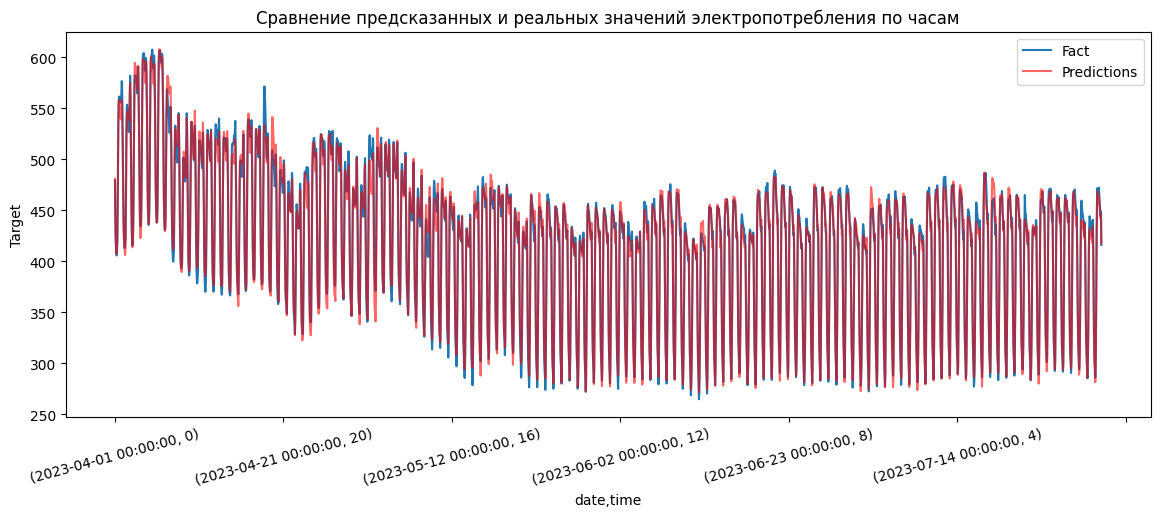

In [139]:
# График сравнения предсказаний и реальных значений
test['prediction'] = predicted_test
plt.figure(figsize=(14, 5))
test.set_index(['date', 'time'])['target'].plot(ylabel='Target')
test.set_index(['date', 'time'])['prediction'].plot(alpha=0.6, color='r')
plt.legend(['Fact', 'Predictions'])
plt.title('Сравнение предсказанных и реальных значений электропотребления по часам')
plt.xticks(rotation=15)
plt.show()


### Оценка важности признаков

In [147]:
pd.DataFrame(best_model[1].estimators_[0].feature_importances_, 
             index=features_train.drop('date', axis=1).columns,
            columns=['Feature importance']).sort_values(
                                    by='Feature importance', ascending=False).style.background_gradient()

,Feature importance
dayofyear,2210
temp_variance_24h,1945
dayofmonth,1912
temp_lag,1618
temp_pred,1556
diff_day,1458
lag_day_24,1353
dayofweek,1180
humidity,1024
year,725
